Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Необходимо довести метрику до 0.59. Проверим *F1*-меру на тестовой выборке.

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
#импортируем требуемые библиотеки
import pandas as pd
from random import randrange
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from joblib import dump
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<b>Успех:</b> Правильное решение — выделять отдельную ячейку в начале проекта под подключение библиотек и настройки. Tак код легче поддерживать 👌
</div>

In [2]:
#загрузим датасет
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Как мы видим  имеются пропуски в столбце "Tenure" и они составляют около 10% от датасета. Заменим пропуски случайными значениями продолжительности использования клтентами банковскими услугами

In [5]:
#заполним пропуски случайными значениями от 0 до 10
data['Tenure']=data['Tenure'].fillna(randrange(0, 10, 1))

## Исследование задачи

Исследуем распределение частоты критерия по признакам. 

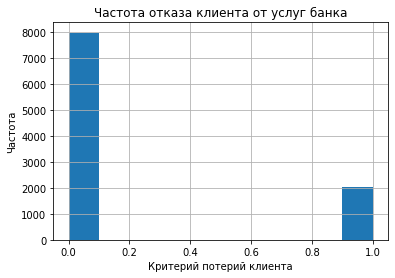

In [6]:
data['Exited'].hist()
plt.title('Частота отказа клиента от услуг банка')
plt.xlabel('Критерий потерий клиента')
plt.ylabel('Частота');

In [7]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Как мы видим, что распределение предельно неравнозначно (положительных результатов в 4 раза меньше).

## Борьба с дисбалансом

### Метод увеличения выборки

Исключим признаки с номером строки, id клиента и фамилию.

In [8]:
data_ohe = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

Ввиду того, что данные содержат как численные, так и категориальные признак, необходимо преобразовать данные. Применим метод прямого кодирования (OHE), следующим шагом сбалансируем данные в части объёма по признаку факта ухода клиента и завершим стандартизацией значений.

In [9]:
data_ohe = pd.get_dummies(data_ohe, drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'], axis=1)

Разобьём выборку данных на обучающую, валидационную и тестовую.

In [10]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_test_1, features_valid_1, target_test_1, target_valid_1 = train_test_split(
    features_valid_1, target_valid_1, test_size=0.5, random_state=123)

print('features_train',features_train_1.shape)
print('features_valid',features_valid_1.shape)
print('features_test',features_test_1.shape)
print('target_train',target_train_1.shape)
print('target_valid',target_valid_1.shape)
print('target_test',target_test_1.shape)

features_train (6000, 11)
features_valid (2000, 11)
features_test (2000, 11)
target_train (6000,)
target_valid (2000,)
target_test (2000,)


Напишем функцию для уравнивания и перемешивания данных при дисбалансе методом увеличения целевых значений с результатом 1.

In [11]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_1, target_train_1 = upsample(features_train_1, target_train_1, 4)

In [12]:
target_train_1.value_counts()

0    4804
1    4784
Name: Exited, dtype: int64

Как мы видим баланс практически идеально соблюдён.

Стандартизируем числовые данные, для исключения веса каждого из них в обучении модели:

In [13]:
numeric = ['CreditScore', 
           'Age',
           'Tenure',
           'Balance',
           'NumOfProducts',
           'HasCrCard',
           'IsActiveMember',
           'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train_1[numeric])
features_train_1[numeric] = scaler.transform(features_train_1[numeric])
features_valid_1[numeric] = scaler.transform(features_valid_1[numeric])
features_test_1[numeric] = scaler.transform(features_test_1[numeric])

Обучим модель методом логистической регрессии для последующего сравнения с ней.

In [14]:
model_1 = LogisticRegression(random_state=12345, solver='liblinear')
model_1.fit(features_train_1, target_train_1)
predicted_valid_1 = model_1.predict(features_valid_1)
probabilities_valid_1 = model_1.predict_proba(features_valid_1)
probabilities_one_valid_1 = probabilities_valid_1[:, 1]

print('AUC-ROC:', roc_auc_score(target_valid_1,probabilities_one_valid_1))
print('F1:', f1_score(target_valid_1,predicted_valid_1))

AUC-ROC: 0.7484271584627433
F1: 0.47807394668959596


Оценим качество модели методом случайного леса с перебором глубины модели от 1 до 20 с шагом 1.

In [15]:
for depth in range(1, 21, 1):
    model_1 = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345)
    model_1.fit(features_train_1, target_train_1)
    predicted_valid_1 = model_1.predict(features_valid_1)
    print("Глубина",depth, f1_score(target_valid_1, predicted_valid_1))

Глубина 1 0.5393939393939393
Глубина 2 0.5436179981634527
Глубина 3 0.5615023474178403
Глубина 4 0.5903257650542942
Глубина 5 0.591044776119403
Глубина 6 0.5900000000000001
Глубина 7 0.5983772819472617
Глубина 8 0.6042726347914547
Глубина 9 0.6114649681528663
Глубина 10 0.593311758360302
Глубина 11 0.6022222222222222
Глубина 12 0.593607305936073
Глубина 13 0.5971563981042655
Глубина 14 0.5973715651135006
Глубина 15 0.5767790262172284
Глубина 16 0.5952677459526775
Глубина 17 0.5833333333333334
Глубина 18 0.5770750988142292
Глубина 19 0.5822454308093995
Глубина 20 0.5785340314136125


Оценим качество модели методом случайного леса с глубиной 9 (как самая эффективная) и перебором количества деревьев от 40 до 200 с шагом 20.

In [29]:
for estimators in range(40, 220, 20):
    model_1 = RandomForestClassifier(n_estimators=estimators, max_depth=9, random_state=12345)
    model_1.fit(features_train_1, target_train_1)
    predicted_valid_1 = model_1.predict(features_valid_1)
    print("Количество деревьев",estimators, f1_score(target_valid_1, predicted_valid_1))

Количество деревьев 40 0.6050420168067228
Количество деревьев 60 0.5980911983032874
Количество деревьев 80 0.5970464135021096
Количество деревьев 100 0.6063157894736843
Количество деревьев 120 0.6037735849056605
Количество деревьев 140 0.6014721345951629
Количество деревьев 160 0.6027397260273973
Количество деревьев 180 0.6033755274261603
Количество деревьев 200 0.6071428571428573


Как видим лучшие показатели у модели с количеством деревьев равным 40.

In [30]:
model_1 = RandomForestClassifier(n_estimators=40, max_depth=9, random_state=12345)
model_1.fit(features_train_1, target_train_1)
predicted_valid_1 = model_1.predict(features_valid_1)
probabilities_valid_1 = model_1.predict_proba(features_valid_1)
probabilities_one_valid_1 = probabilities_valid_1[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid_1,probabilities_one_valid_1))
print('F1:', f1_score(target_valid_1,predicted_valid_1))

AUC-ROC: 0.8559030223704801
F1: 0.6050420168067228


Итого лучшие результаты показала модель с гиперпараметрами глубины равной 9 и количеством деревьев равным 40.

Оценим как себя показывает метод древа решений.

In [31]:
best_model_1 = None
best_result_1 = 0
best_depth_1 = 0
for depth in range(1, 20):
    model_tree = DecisionTreeClassifier(random_state=123, max_depth=depth) 
    model_tree.fit(features_train_1,target_train_1) 
    predictions_1 = model_tree.predict(features_valid_1) 
    result = f1_score(target_valid_1,predictions_1)
    if result > best_result_1:
        best_model_1 = model_tree
        best_result_1 = result
        best_depth_1 = depth
print("Точность лучшей модели с глубиной", best_depth_1, ":", best_result_1)

Точность лучшей модели с глубиной 5 : 0.5795574288724973


Итого следует отметить, что в случае обучения с использованием метода борьбы с дисбалансом расширения выборки лучший результат показал метод случайного леса с гиперпараметрами глубины 9 и количеством деревьев 40.

### Метод уменьшения выборки

Повторно разобьём выборку данных на обучающую, валидационную и тестовую.

In [19]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_test_2, features_valid_2, target_test_2, target_valid_2 = train_test_split(
    features_valid_2, target_valid_2, test_size=0.5, random_state=123)

print('features_train',features_train_2.shape)
print('features_valid',features_valid_2.shape)
print('features_test',features_test_2.shape)
print('target_train',target_train_2.shape)
print('target_valid',target_valid_2.shape)
print('target_test',target_test_2.shape)

features_train (6000, 11)
features_valid (2000, 11)
features_test (2000, 11)
target_train (6000,)
target_valid (2000,)
target_test (2000,)


Напишем функцию для уравнивания и перемешивания данных при дисбалансе методом снижения целевых значений с результатом 0.

In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_train_2, target_train_2 = downsample(features_train_2, target_train_2, 0.25)

In [21]:
target_train_2.value_counts()

0    1201
1    1196
Name: Exited, dtype: int64

Как мы видим баланс соблюдён.

Стандартизируем числовые данные, для исключения веса каждого из них в обучении модели:

In [22]:
numeric = ['CreditScore', 
           'Age',
           'Tenure',
           'Balance',
           'NumOfProducts',
           'HasCrCard',
           'IsActiveMember',
           'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train_2[numeric])
features_train_2[numeric] = scaler.transform(features_train_2[numeric])
features_valid_2[numeric] = scaler.transform(features_valid_2[numeric])
features_test_2[numeric] = scaler.transform(features_test_2[numeric])

Обучим модель методом логистической регрессии для последующего сравнения с ней.

In [23]:
model_2 = LogisticRegression(random_state=12345, solver='liblinear')
model_2.fit(features_train_2, target_train_2)
predicted_valid_2 = model_2.predict(features_valid_2)
probabilities_valid_2 = model_2.predict_proba(features_valid_2)
probabilities_one_valid_2 = probabilities_valid_2[:, 1]

print('AUC-ROC:', roc_auc_score(target_valid_2,probabilities_one_valid_2))
print('F1:', f1_score(target_valid_2,predicted_valid_2))

AUC-ROC: 0.7473152242577384
F1: 0.47986289631533846


Оценим качество модели методом случайного леса с перебором глубины модели от 1 до 20 с шагом 1.

In [24]:
for depth in range(1, 21, 1):
    model_2 = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345)
    model_2.fit(features_train_2, target_train_2)
    predicted_valid_2 = model_2.predict(features_valid_2)
    print("Глубина",depth, f1_score(target_valid_2, predicted_valid_2))

Глубина 1 0.5501379944802207
Глубина 2 0.5493934142114385
Глубина 3 0.5532286212914486
Глубина 4 0.5708920187793427
Глубина 5 0.5852749301025162
Глубина 6 0.5771689497716895
Глубина 7 0.5778611632270169
Глубина 8 0.5855513307984791
Глубина 9 0.5727969348659004
Глубина 10 0.5609532538955087
Глубина 11 0.5687558465855941
Глубина 12 0.5655042412818095
Глубина 13 0.5570093457943925
Глубина 14 0.5474452554744524
Глубина 15 0.5631970260223048
Глубина 16 0.5546218487394958
Глубина 17 0.5552353506243995
Глубина 18 0.560303893637227
Глубина 19 0.5523809523809523
Глубина 20 0.5578747628083491


Как видим наилучшие показатели в случае глубины равной 8.

In [32]:
for estimators in range(20, 220, 20):
    model_2 = RandomForestClassifier(n_estimators=estimators, max_depth=8, random_state=12345)
    model_2.fit(features_train_2, target_train_2)
    predicted_valid_2 = model_2.predict(features_valid_2)
    print("Количество деревьев",estimators, f1_score(target_valid_2, predicted_valid_2))

Количество деревьев 20 0.5855513307984791
Количество деревьев 40 0.5796831314072692
Количество деревьев 60 0.5932203389830508
Количество деревьев 80 0.5915492957746479
Количество деревьев 100 0.592662276575729
Количество деревьев 120 0.5891181988742964
Количество деревьев 140 0.5946969696969696
Количество деревьев 160 0.5975494816211122
Количество деревьев 180 0.5913370998116761
Количество деревьев 200 0.5883458646616542


Лучший результат с количеством деревьев 160 и глубиной 8.

Оценим как себя показывает метод древа решений.

In [26]:
best_model_2 = None
best_result_2 = 0
best_depth_2 = 0
for depth in range(1, 20):
    model_tree = DecisionTreeClassifier(random_state=123, max_depth=depth) 
    model_tree.fit(features_train_2,target_train_2) 
    predictions_2 = model_tree.predict(features_valid_2) 
    result = f1_score(target_valid_2,predictions_2)
    if result > best_result_2:
        best_model_2 = model_tree
        best_result_2 = result
        best_depth_2 = depth
print("Точность лучшей модели с глубиной", best_depth_1, ":", best_result_1)

Точность лучшей модели с глубиной 5 : 0.5795574288724973


Итого с что в случае обучения с использованием метода борьбы с дисбалансом уменьшения выборки лучший результат также показал метод случайного леса с гиперпараметрами глубины 8 и количеством деревьев 160, но несколько худший нежели в случае с увеличением выборки.

## Тестирование модели

Проверим качество обученной моделм на тестовой выборке данных:

In [27]:
predicted_test = model_1.predict(features_test_1)
probabilities_test = model_1.predict_proba(features_test_1)
probabilities_one_test = probabilities_test[:, 1]
print('AUC-ROC:', roc_auc_score(target_test_1,probabilities_one_test))
print('F1:', f1_score(target_test_1,predicted_test))

AUC-ROC: 0.8477591346614308
F1: 0.6182669789227166


Построим ROC-кривую для логистической регрессии и для наглядности также построим график ROC-кривой случайной модели

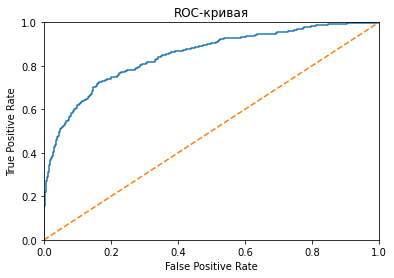

In [28]:
fpr, tpr, thresholds = roc_curve(target_test_1, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

Как видим из графика результат обученной модели показывает хорошие результаты.

Резюмирую можно сказать, что прогнозная модель обучена и позволит решить задачу банка, а именно:

- Предсказать клиентов, которые в будующем могут отказаться от услуг банка
- Необходимо проанализировать зависимость и общие черты отобранных клиентов и оценить факторы на которые может повлиять банк, а именно проявить некоторую лояльность (сниженные ставки, особые условия обслуживания с персональным менеджером и т.д.)